In [45]:
import networkx as nx
import numpy as np
import random
import statistics

In [46]:
def const_probability(depth):
    # Return constant probability independent of depth.
    return 0.98

In [47]:
def prob_one(depth):
    return 1.0

In [48]:
def decay_probability(depth):
    # Return decaying probability with recursion depth.
    return 1.0/depth

In [49]:
def pop_next_node(V_extension):
    i = np.random.randint(len(V_extension))
    V_extension[i], V_extension[-1] = V_extension[-1], V_extension[i]
    return V_extension.pop()

def get_exclusive_neighbors(V_subgraph, next_node, v, graph):
    current_neighbors = []
    for u in V_subgraph:
        current_neighbors += list(nx.neighbors(graph, u))
    current_neighbors = set(current_neighbors + V_subgraph)
    exclusive_neighbors = []
    for neighbor in nx.neighbors(graph, next_node):
            if neighbor > v and neighbor not in current_neighbors:
                exclusive_neighbors.append(neighbor)
    return exclusive_neighbors

In [50]:
def extend_subgraph(V_subgraph, V_extension, v, k, graph, all_subgraphs, depth, prob_function):
    if len(V_subgraph) == k:
        all_subgraphs.append(nx.induced_subgraph(graph, V_subgraph))
        return
    while len(V_extension) > 0:
        next_node = pop_next_node(V_extension)
        exclusive_neighbors = get_exclusive_neighbors(V_subgraph, next_node, v, graph)
        # Recurse down only with given probability.
        prob = prob_function(depth)
        if random.random() <= prob:
            extend_subgraph(V_subgraph + [next_node], V_extension + exclusive_neighbors, v, k, graph, all_subgraphs, depth+1, prob_function)
        
def enumerate_subgraphs(graph, k, prob_function):
    all_subgraphs = []
    for v in range(graph.number_of_nodes()):
        V_subgraph = [v]
        V_extension = [neighbor for neighbor in nx.neighbors(graph, v) if neighbor > v]
        # Only process node with probability p0.
        prob = prob_function(1)
        if random.random() <= prob:
            extend_subgraph(V_subgraph, V_extension, v, k, graph, all_subgraphs, 2, prob_function)
    return all_subgraphs

In [51]:
def to_equivalence_classes(all_subgraphs):
    representatives = []
    counts = []
    num_classes = 0
    for subgraph in all_subgraphs:
        new_class = True
        for i in range(num_classes):
            if nx.is_isomorphic(subgraph, representatives[i]):
                counts[i] += 1
                new_class = False
                break
        if new_class:
            representatives.append(subgraph)
            counts.append(1)
            num_classes += 1
    return list(zip(representatives,counts,[count / len(all_subgraphs) for count in counts]))

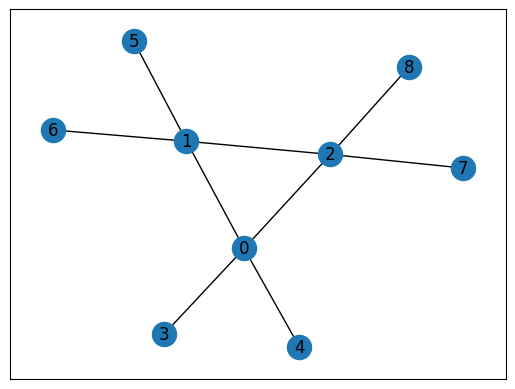

In [52]:
graph = nx.Graph([(7,2),(8,2),(2,0),(2,1),(3,0),(0,1),(1,6),(0,4),(1,5)])
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, pos=pos)

In [53]:
all_subgraphs = enumerate_subgraphs(graph, 3, prob_one)
equivalence_classes = to_equivalence_classes(all_subgraphs)
print(f'Number of equivalence classes: {len(equivalence_classes)}')
print(equivalence_classes)

Number of equivalence classes: 2
[(<networkx.classes.graph.Graph object at 0x72c204d96d40>, 15, 0.9375), (<networkx.classes.graph.Graph object at 0x72c204d951e0>, 1, 0.0625)]


In [54]:
if len(equivalence_classes)==1:
    equivalence_classes.append((nx.Graph(), 0, 0.0))

print(f'Concentration 1: {equivalence_classes[0][2]}')
print(f'Concentration 2: {equivalence_classes[1][2]}')
#nx.draw(equivalence_classes[0][0])
#nx.draw(equivalence_classes[1][0])

Concentration 1: 0.9375
Concentration 2: 0.0625


In [55]:
# Compute both eq. class once before.
all_subgraphs = enumerate_subgraphs(graph, 3, prob_one)
equivalence_classes = to_equivalence_classes(all_subgraphs)
samples = {equivalence_classes[0][0]: [], equivalence_classes[1][0]: []}

# Compute mean of several random sampling runs.
NUM_RUNS = 1000
for _ in range(NUM_RUNS):
    all_subgraphs = enumerate_subgraphs(graph, 3, const_probability)
    equivalence_classes = to_equivalence_classes(all_subgraphs)

    # Store sampled concentration in corresponding entry.
    for el in equivalence_classes:
        for key, val in samples.items():
            if nx.is_isomorphic(el[0], key):
                val.append(el[2])

# Compute mean of both sampled classes.
for key, val in samples.items():
    print(f'Mean concentration of class is: {statistics.mean(val)}.')
    

Mean concentration of class is: 0.9388818334443334.
Mean concentration of class is: 0.06522749899217349.
